!pip install pybounds

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

from math import ceil,floor
from pybounds import Simulator#, SlidingEmpiricalObservabilityMatrix, FisherObservability, SlidingFisherObservability, ObservabilityMatrixImage, colorline
from scipy.interpolate import make_interp_spline
from PFN_model import PFN, BuildSSInitial
import utils
from utils import unwrap_angle


C:\Users\mayc06\AppData\Local\anaconda3\envs\CelliniWindSim\Lib\site-packages\do_mpc\sysid\__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
C:\Users\mayc06\AppData\Local\anaconda3\envs\CelliniWindSim\Lib\site-packages\do_mpc\opcua\__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Define system dynamics and measurements
This example uses a model of an insect flying in the presence of wind.

See the following reference for details:

Floris van Breugel
A Nonlinear Observability Analysis of Ambient Wind Estimation with Uncalibrated Sensors, Inspired by Insect Neural Encoding
2021 60th IEEE Conference on Decision and Control (CDC)
DOI: 10.1109/CDC45484.2021.9683219

The system dynamics are described by seven primary states:
* altitude $z$
* parallel velocity $v_{\parallel}$
* perpendicular velocity $v_{\perp}$
* heading $\phi$
* angular velocity $\dot{\phi}$
* wind speed $w$
* wind direction $\zeta$

And the system dynamics are given by
$$
\dot{\mathbf{x}} = \begin{bmatrix} \dot{z} \\ \dot{v}_{\parallel} \\ \dot{v}_{\perp} \\ \dot{\phi} \\ \ddot{\phi} \\ \dot{w}  \\ \dot{\zeta} \end{bmatrix} =
f(\mathbf{x}) = \begin{bmatrix}
\dot{z} \\
\frac{1}{m}(k_{m_1}u_{\parallel} - C_{\parallel} a_{\parallel}) + v_{\perp} \dot{\phi} \\
 \frac{1}{m}(k_{m_3}u_{\perp} - C_{\perp} a_{\perp}) - v_{\parallel} \dot{\phi} \\
  \dot{\phi} \\
   \frac{1}{I}(k_{m_4}u_{\phi} - C_{\phi} \dot{\phi} + k_{m_2} u_{\perp}) \\
    \dot{w} \\
     \dot{\zeta} \\
\end{bmatrix}
$$

where the air velocity is given by

$$
\begin{bmatrix} a_{\parallel} \\ a_{\perp} \end{bmatrix} =  \begin{bmatrix} v_{\parallel} - w \cos(\phi - \zeta) \\ v_{\perp} + w \sin(\phi - \zeta) \end{bmatrix}
$$
The inputs $u_{\bullet}$ are
* parallel thrust force $u_{\parallel}$
* perpendicular thrust force $u_{\perp}$
* turning torque $u_{\phi}$

The inertia parameters (mass $m$ and inertia $I$), damping terms $C_{\bullet}$, and motor calibration coefficients $k_{m_{\bullet}}$ can also be considered states. Other auxiliary states, like the $x$ and $y$ position can also be added.

The putative system measurements are:
* heading $\phi$
* ground speed angle $\psi$
* apparent airflow angle $\gamma$
* apparent airflow magnitude $a$
* ground speed magnitude $g$
* optic flow $g/z$

Where the measurement function is given by:

$$
\mathbf{y} = h(\mathbf{x}) = \begin{bmatrix} \phi \\ \psi \\ \gamma  \\ a \\ g \\ r \end{bmatrix} =
\begin{bmatrix} \phi \\
\arctan(v_{\perp}/ v_{\parallel}) \\
\arctan(a_{\perp} / a_{\parallel}) \\
\sqrt{a_{\parallel}^2 + a_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} \\
\sqrt{v_{\parallel}^2 + v_{\perp}^2} / z \\
\end{bmatrix}
$$



## Define dynamics function
The dynamics function takes in a list of states $X$ and a list of inputs $U$ and outputs the derivative of the states.

The optional state & input names must be in the same order as the states & inputs in $X$ & $U$.

In [11]:
state_names = ['x',  # x position [m]
               'y',  # y position [m]
               'z',  # z position (altitude) [m]
               'v_para',  # parallel velocity [m/s]
               'v_perp',  # perpendicular velocity [m/s]
               'phi', # heading [rad]
               'phi_dot',  # angular velocity [rad/s]
               'w',  # ambient wind speed [m/s]
               'zeta',  # ambient wind angle [rad]
               'm', # mass [kg]
               'I',  # inertia [kg*m^2]
               'C_para',  # parallel damping [N*s/m]
               'C_perp',  # perpendicular damping [N*s/m]
               'C_phi',  # rotational damping [N·m/rad/s]
               'km1',  # parallel motor calibration coefficient
               'km2',  # offset motor calibration coefficient
               'km3',  # perpendicular motor calibration coefficient
               'km4',  # rotational motor calibration coefficient
               ]

input_names = ['u_para',  # parallel thrust force [N]
               'u_perp',  # perpendicular thrust force [N]
               'u_phi'#,  # torque [N*m]
               #'u_w',                                                            ####
               #'u_zeta'                                                          ####
               ]
def f(X, U):
    # States
    x, y, z, v_para, v_perp, phi, phi_dot, w, zeta, m, I, C_para, C_perp, C_phi, km1, km2, km3, km4 = X

    # Inputs
    u_para, u_perp, u_phi = U
    #u_para, u_perp, u_phi, u_w, u_zeta = U                                       ####

    # Air velocity
    a_para = v_para - w * np.cos(phi - zeta)
    a_perp = v_perp + w * np.sin(phi - zeta)

    # Acceleration
    v_para_dot = ((km1 * u_para - C_para * a_para) / m) + (v_perp * phi_dot)
    v_perp_dot = ((km3 * u_perp - C_perp * a_perp) / m) - (v_para * phi_dot)

    # Angular acceleration
    phi_ddot = (km4 * u_phi / I) - (C_phi * phi_dot / I) + (km2 * u_para / I)

    # Other dynamics
    x_dot = v_para * np.cos(phi) - v_perp * np.sin(phi)
    y_dot = v_para * np.sin(phi) + v_perp * np.cos(phi)
    z_dot = 0*x
    w_dot = 0*x                                                                ####
    #w_dot = w * u_w
    zeta_dot = 0*x                                                             ####
    #zeta_dot = zeta * u_zeta
    m_dot = 0*x
    I_dot = 0*x
    C_para_dot = 0*x
    C_perp_dot = 0*x
    C_phi_dot = 0*x
    km1 = 0*x
    km2 = 0*x
    km3 = 0*x
    km4 = 0*x

    # Package and return xdot
    x_dot = [x_dot, y_dot, z_dot, v_para_dot, v_perp_dot, phi_dot, phi_ddot, w_dot, zeta_dot, m_dot, I_dot, C_para_dot, C_perp_dot, C_phi_dot, km1, km2, km3, km4]

    return x_dot

## Define measurement function
The measurement function takes in a list of states $X$ and a list of inputs $U$ and outputs the measurements $Y$.

The optional measurement names must be in the same order as the measurements in $Y$.

In [12]:
measurement_names = ['phi', 'psi', 'gamma', 'a', 'g', 'r']
def h(X, U):
    # States
    x, y, z, v_para, v_perp, phi, phi_dot, w, zeta, m, I, C_para, C_perp, C_phi, km1, km2, km3, km4 = X

    # Inputs
    u_para, u_perp, u_phi = U
    #u_para, u_perp, u_phi, u_w, u_zeta = U                                     ####

    # Air velocity
    a_para = v_para - w * np.cos(phi - zeta)
    a_perp = v_perp + w * np.sin(phi - zeta)
    a = np.sqrt(a_para ** 2 + a_perp ** 2)
    gamma = np.arctan2(a_perp, a_para)  # air velocity angle

    # Course direction in fly reference frame
    g = np.sqrt(v_para ** 2 + v_perp ** 2)
    psi = np.arctan2(v_perp, v_para)

    # Optic flow
    r = g / z

    # Unwrap angles
    if np.array(phi).ndim > 0:
        if np.array(phi).shape[0] > 1:
            phi = np.unwrap(phi)
            psi = np.unwrap(psi)
            gamma = np.unwrap(gamma)

    # Measurements
    Y  = [phi, psi, gamma, a, g, r]

    # Return measurement
    return Y


## Set time-step

In [6]:
dt = 0.01  # [s]


## CEM
dt = 0.002

# Create simulator object

simulator = Simulator(f, h, dt=dt, state_names=state_names, input_names=input_names, measurement_names=measurement_names)

### Can also set the number of state (n) & inputs (m0 instead of state & input names)
### simulator = Simulator(f, h, dt=dt, n=len(state_names), m=len(input_names))

# Set up model predictive control

In [13]:
# Parameters in SI units
m = 0.25e-6  # [kg]
I = 5.2e-13  # [N*m*s^2] yaw mass moment of inertia: 10.1242/jeb.02369
# I = 4.971e-12  # [N*m*s^2] yaw mass moment of inertia: 10.1242/jeb.038778
C_phi = 27.36e-12  # [N*m*s] yaw damping: 10.1242/jeb.038778
C_para = m / 0.170  # [N*s/m] calculate using the mass and time constant reported in 10.1242/jeb.098665
C_perp = C_para  # assume same as C_para

# Scale Parameters
m = m * 1e6  # [mg]
I = I * 1e6 * (1e3) ** 2  # [mg*mm/s^2 * mm*s^2]
C_phi = C_phi * 1e6 * (1e3) ** 2  # [mg*mm/s^2 *m*s]
C_para = C_para * 1e6  # [mg/s]
C_perp = C_perp * 1e6  # [mg/s]

In [14]:
# Define the set-point(s) to follow

# CEM trajectory parameter initial values for subsetAplus
fs = 500   # 500 for Mayetal2025
dt = 1 / fs
T = 0.1
tsim = np.arange(0.0, T + 0.9*dt, dt)

#v_para_0 = [0.125,0.25,1.0]                # subsetAplus
#v_para_0 = [0.25]                                     ###
v_para_0 = np.linspace(0.15,0.9,4)         # like real WVG
v_para_dot_0 = 2.5/int(np.floor(len(tsim)/2))/dt

v_perp_0 = 0.0
v_perp_dot_0 = 0.0

deltaPhi = np.linspace(-np.pi,np.pi,num=26)
#deltaPhia = np.array([deltaPhi[i*3] for i in range(7)])
deltaPhib = np.array([deltaPhi[i*3 + 2] for i in range(7)])
#deltaPhi = np.append(deltaPhia,deltaPhib)
deltaPhi = np.append(deltaPhib,-deltaPhib[0])

phi_0 = np.linspace(-np.pi,np.pi,num=19)
phi_0[0]=-np.pi+0.02
phi_0[9]=0.02
phi_0[-1]=np.pi-0.02
a=phi_0[7]
b=phi_0[11]
phi_0 = [phi_0[i*3] for i in range(6)]
addition = [a,b]     
#addition = [np.pi-0.02,a,b]               # subsetAplus
for i in addition: phi_0.append(i)
phi_0.sort()

# = [0.1,0.5,2.0]                       # subsetAplus
w_0 = np.linspace(0.0,0.6,num=5)          # like real WVG
#w_0 = [0]

zeta_0 = np.linspace(-np.pi+0.04,np.pi+0.04,10)
zeta_0 = zeta_0[:9]
zeta_0 = np.hstack((zeta_0[:4],zeta_0[5:]))

elev = [0.3,1.0,2.0]

In [35]:
deltaPhi

array([-2.63893783, -1.88495559, -1.13097336, -0.37699112,  0.37699112,
        1.13097336,  1.88495559,  2.63893783])

## Setup for heading predictor model

In [15]:
from keras.models import load_model
from heading_predictor_functions import augment_with_time_delay_embedding, predict_heading_from_fly_trajectory

## Heading Predictor setup.
predictor_input_names = [
    'groundspeed',
    'groundspeed_angle',
    'airspeed',
    'airspeed_angle',
    'thrust',
    'thrust_angle',
]

predictor_output_names = ['heading_angle_x', 'heading_angle_y']

time_window = 4

time_augmentation_kwargs = {
    "time_window": time_window,
    "input_names": predictor_input_names,
    "output_names": predictor_output_names,
    "direction": "backward"
}

headingPredictor=load_model('model_CEM_all-angle-rotate.keras')

In [8]:
n_traj = len(elev)*len(deltaPhi)*len(zeta_0)*len(w_0)*len(phi_0)*len(v_para_0)
print(len(v_para_0),len(elev),len(w_0),len(zeta_0),len(deltaPhi),len(phi_0))

4 3 5 8 8 8


In [9]:
print(n_traj)

30720


In [18]:
stimfile.close()
PFNfile.close()

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
# CEM calculate dynamics of the trajectory
stimulus = pd.DataFrame()
PFNdf = pd.DataFrame()

stimfilename = 'real-wvg-like_withHeadingPredictor_yesdownsample_stims_pt2'
stimfilename = stimfilename+'.csv'
stimfile = open(stimfilename, 'a')

PFNfilename = 'ANN-PFNinputs_real-wvg-like_withHeadingPredictor_yesdownsample_pt2'
PFNfilename = PFNfilename+'.csv'
PFNfile = open(PFNfilename, 'a')

n_traj = len(elev)*len(deltaPhi)*len(zeta_0)*len(w_0)*len(phi_0)*len(v_para_0)
count=0
for v in v_para_0:
    for el in elev:
        for wsp in w_0:
            for z in zeta_0:
                for d in deltaPhi:
                    for s in phi_0:
                        
                        if count>=20520:
                            simulator = Simulator(f, h, dt=dt, state_names=state_names, input_names=input_names, measurement_names=measurement_names)

                            vpara_start = v*np.ones_like(tsim)
                            accel = v_para_dot_0*np.square(tsim[0:ceil(len(tsim)/2)])
                            v_para = vpara_start - np.append(accel,np.flip(accel[:-1]))
                            v_perp = v_perp_0*np.ones_like(tsim) + v_perp_dot_0*tsim
                            phi_start = s*np.ones_like(tsim)
                            angaccel = (d)/(1+np.exp(-100*(tsim-0.052)))
                            phi = phi_start + angaccel
                            w = wsp*np.ones_like(tsim)
                            zeta = z*np.ones_like(tsim)
                            alt = el*np.ones_like(tsim)


                            setpoint_CEM = {'x': 0.0 * np.ones_like(tsim),
                                            'y': 0.0 * np.ones_like(tsim),
                                            'z': alt,
                                            'v_para': v_para,
                                            'v_perp': v_perp,
                                            'phi': phi,
                                            'phi_dot': 0.0*np.ones_like(tsim),
                                            'w': 0.0*np.ones_like(tsim),         ###
                                            'zeta': 0.0*np.ones_like(tsim),      ###
                                            'm': m * np.ones_like(tsim),
                                            'I': I * np.ones_like(tsim),
                                            'C_para': C_para * np.ones_like(tsim),
                                            'C_perp': C_perp * np.ones_like(tsim),
                                            'C_phi': C_phi * np.ones_like(tsim),
                                            'km1': 1.0 * np.ones_like(tsim),
                                            'km2': 0.0 * np.ones_like(tsim),
                                            'km3': 1.0 * np.ones_like(tsim),
                                            'km4': 1.0 * np.ones_like(tsim),
                                           }

                            # Update the simulator set-point
                            simulator.update_dict(setpoint_CEM, name='setpoint')

                            # Define cost function: penalize the squared error between parallel & perpendicular velocity and heading
                            cost = ((simulator.model.x['v_para'] - simulator.model.tvp['v_para_set']) ** 2 +
                                    (simulator.model.x['v_perp'] - simulator.model.tvp['v_perp_set']) ** 2 +
                                    (simulator.model.x['phi'] - simulator.model.tvp['phi_set']) ** 2 #+
                                    #(simulator.model.x['w'] - simulator.model.tvp['w_set']) ** 2 + 
                                    #(simulator.model.x['zeta'] - simulator.model.tvp['zeta_set']) ** 2
                                   )

                            # Set cost function
                            simulator.mpc.set_objective(mterm=cost, lterm=cost)

                            # Set input penalty: make this small for accurate state following
                            simulator.mpc.set_rterm(u_para=1e-6, u_perp=1e-6, u_phi=1e-6)

                            t_sim1, x_sim1, u_sim, y_sim1 = simulator.simulate(x0=None, mpc=True, return_full_output=True)

                            t_sim, x_sim, u_sim2, y_sim = simulator.simulate(x0={'w':wsp,'zeta':z}, mpc=False, u=u_sim, return_full_output=True)

                            trajec = pd.DataFrame()
                            trajec['timestamp'] = tsim
                            trajec['groundspeed'] = y_sim['g']
                            trajec['groundspeed_angle'] = y_sim['psi']+y_sim['phi']
                            trajec['thrust'] = np.sqrt(u_sim['u_para']**2 + u_sim['u_perp']**2)
                            trajec['thrust_angle'] = np.tan(u_sim['u_perp']/u_sim['u_para'])
                            trajec['airspeed'] = y_sim['a']
                            trajec['airspeed_angle'] = y_sim['gamma']+y_sim['phi']
                            trajec['position_x'] = x_sim['x']
                            trajec['position_y'] = x_sim['y']
                            trajec['heading_angle_x'] = np.cos(y_sim['phi'])
                            trajec['heading_angle_y'] = np.sin(y_sim['phi'])


                            # To downsample CEM data
                            #trajec = trajec.loc[np.linspace(0,50,11)]
                            trajec = trajec.loc[np.arange(0,len(t_sim1),int(0.01/0.002))]
                            trajec.reset_index(drop=True,inplace=True)

                            heading_angle_predicted = predict_heading_from_fly_trajectory(trajec, 
                                                                                          24,
                                                                                          augment_with_time_delay_embedding, 
                                                                                          headingPredictor, smooth=True,
                                                                                          **time_augmentation_kwargs)
                            
                            head_pred_unwrap = utils.unwrap_angle(heading_angle_predicted)

                            stimulus['time'] = tsim
                            stimulus['obj_id'] = count
                            stimulus['heading'] = np.nan
                            stimulus['heading'].loc[np.arange(0,len(t_sim1),int(0.01/0.002))] = np.round(head_pred_unwrap,6)
                            stimulus['heading'].interpolate(method='cubic',inplace=True)
                            stimulus['course_dir'] = np.round(y_sim['phi'],6)
                            stimulus['airspeed'] = np.round(y_sim['a'],6)
                            stimulus['gamma'] = np.round(y_sim['gamma'],6)
                            stimulus['gspd'] = np.round(y_sim['r'],6)
                            stimulus['psi'] = np.round(y_sim['psi'],6)
                            stimulus['zeta'] = np.round(x_sim['zeta'],6)
                            stimulus['wspd'] = np.round(x_sim['w'],6)
                            stimulus['altitude'] = np.round(x_sim['z'],6)
                            stimulus['fspd'] = np.round(y_sim['g'],6)
                            stimulus['thrust'] = np.sqrt(u_sim['u_para']**2 + u_sim['u_perp']**2)
                            stimulus['thrust_angle'] = np.tan(u_sim['u_perp']/u_sim['u_para'])
                            stimulus['torque'] = u_sim['u_phi']
                            stimulus['xpos'] = np.round(x_sim['x'],6)
                            stimulus['ypos'] = np.round(x_sim['y'],6)
                            stimulus['vpara_input'] = v_para
                            stimulus['vperp_input'] = v_perp
                            stimulus['phi_input'] = phi

                            if count == 0:
                                stimulus.to_csv(stimfile)
                            else:
                                stimulus.to_csv(stimfile,header=False)


                            ## Model PFN activity during trajectory
                            pfnmodel = PFN()

                            p_d = pfnmodel.model_param['PFNd']
                            p_v = pfnmodel.model_param['PFNv']
                            p_pc = pfnmodel.model_param['PFNpc']
                            p_a = pfnmodel.model_param['PFNa']
                            AF = [-stimulus['gamma'].copy().iloc[0], 100*stimulus['airspeed'].copy().iloc[0]]
                            OF = [-stimulus['psi'].copy().iloc[0], 100*stimulus['gspd'].copy().iloc[0]]   # "gspd" is actually of speed
                            bump = [-stimulus['heading'].copy().iloc[0], -stimulus['gamma'].copy().iloc[0], 100*stimulus['airspeed'].copy().iloc[0]]
                            initcond = BuildSSInitial(p_d, p_v, p_pc, p_a, AF, OF, bump)

                            pfnmodel.run(tsim=np.array(stimulus['time']),
                                          phi=-np.array(stimulus['heading']),
                                          a=100*np.array(stimulus['airspeed']),
                                          gamma=-np.array(stimulus['gamma']),
                                          g=100*np.array(stimulus['gspd']),
                                          psi=-np.array(stimulus['psi']),
                                          initcond=initcond)

                            inputs = {}

                            neurons = list(pfnmodel.heatmap.keys())
                            labels = {'EPG':['EPG_c1','EPG_c2','EPG_c3','EPG_c4','EPG_c5','EPG_c6','EPG_c7','EPG_c8'],
                                      'PFNdL_pb':['PFNd_c1','PFNd_c2','PFNd_c3','PFNd_c4','PFNd_c5','PFNd_c6','PFNd_c7','PFNd_c8'],
                                      'PFNdR_pb':['PFNd_c9','PFNd_c10','PFNd_c11','PFNd_c12','PFNd_c13','PFNd_c14','PFNd_c15','PFNd_c16'],
                                      'PFNvL_pb':['PFNv_c1','PFNv_c2','PFNv_c3','PFNv_c4','PFNv_c5','PFNv_c6','PFNv_c7','PFNv_c8'],
                                      'PFNvR_pb':['PFNv_c9','PFNv_c10','PFNv_c11','PFNv_c12','PFNv_c13','PFNv_c14','PFNv_c15','PFNv_c16'],
                                      'PFNpcL_pb':['PFNpc_c1','PFNpc_c2','PFNpc_c3','PFNpc_c4','PFNpc_c5','PFNpc_c6','PFNpc_c7','PFNpc_c8'],
                                      'PFNpcR_pb':['PFNpc_c9','PFNpc_c10','PFNpc_c11','PFNpc_c12','PFNpc_c13','PFNpc_c14','PFNpc_c15','PFNpc_c16'],
                                      'PFNaL_pb':['PFNa_c1','PFNa_c2','PFNa_c3','PFNa_c4','PFNa_c5','PFNa_c6','PFNa_c7','PFNa_c8'],
                                      'PFNaR_pb':['PFNa_c9','PFNa_c10','PFNa_c11','PFNa_c12','PFNa_c13','PFNa_c14','PFNa_c15','PFNa_c16']   
                                      }
                            for celltype in neurons:
                                j = 0
                                for label in labels[celltype]:
                                    inputs[label] = pfnmodel.heatmap[celltype][:,j]
                                    j+=1

                            angle_map = np.arange(-np.pi,np.pi,step=np.pi/4)
                            n_angles = angle_map.shape[0]
                            n_sim = stimulus['time'].shape[0]

                            inputs['wind_c1'] = np.empty((n_sim,))
                            inputs['wind_c2'] = np.empty((n_sim,))
                            inputs['wind_c3'] = np.empty((n_sim,))
                            inputs['wind_c4'] = np.empty((n_sim,))
                            inputs['wind_c5'] = np.empty((n_sim,))
                            inputs['wind_c6'] = np.empty((n_sim,))
                            inputs['wind_c7'] = np.empty((n_sim,))
                            inputs['wind_c8'] = np.empty((n_sim,))

                            for pt in range(n_sim):
                                wind = 0.5 + 0.5 * np.cos(angle_map - stimulus['zeta'].iloc[pt] - np.pi)
                                inputs['wind_c1'][pt]=wind[0]
                                inputs['wind_c2'][pt]=wind[1]
                                inputs['wind_c3'][pt]=wind[2]
                                inputs['wind_c4'][pt]=wind[3]
                                inputs['wind_c5'][pt]=wind[4]
                                inputs['wind_c6'][pt]=wind[5]
                                inputs['wind_c7'][pt]=wind[6]
                                inputs['wind_c8'][pt]=wind[7]

                            inputs['obj_id'] = count

                            PFNdf = pd.DataFrame(inputs)
                            if count == 0:
                                PFNdf.to_csv(PFNfile)
                            elif count!=0:
                                PFNdf.to_csv(PFNfile,header=False)
                            
                            print('windspd:'+str(stimulus['wspd'].iloc[0]))
                            
                            print(str(count+1)+' out of '+str(n_traj))

                        count+=1

                        
                        
stimfile.close()
PFNfile.close()
                        

24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20521 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20522 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20523 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20524 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20525 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20526 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20527 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20528 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20529 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20530 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20531 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20532 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20533 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20534 out o

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
windspd:0.0
20598 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20599 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20600 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20601 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20602 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20603 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20604 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20605 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20606 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
20607 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20608 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20609 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20610 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
20611 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
20675 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.0
20676 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
20677 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20678 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20679 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20680 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20681 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20682 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20683 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
20684 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20685 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20686 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20687 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20688 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20752 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20753 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20754 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
20755 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20756 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
windspd:0.0
20757 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20758 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.0
20759 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.0
20760 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20761 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20762 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20763 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
20764 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20765 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20829 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
20830 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20831 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
20832 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20833 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
20834 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
windspd:0.0
20835 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.0
20836 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.0
20837 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20838 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
20839 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20840 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.0
20841 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20842 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.0
20906 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
20907 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20908 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
20909 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20910 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20911 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
20912 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20913 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20914 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
20915 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20916 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20917 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
20918 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
20919 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20983 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.0
20984 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20985 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
20986 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.0
20987 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.0
20988 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20989 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
20990 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
20991 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
20992 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
20993 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
20994 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
20995 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
20996 out 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21059 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
21060 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
21061 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21062 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21063 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21064 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21065 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21066 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.15
21067 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21068 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21069 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21070 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21071 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21135 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21136 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21137 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
21138 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21139 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21140 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
21141 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21142 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
21143 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21144 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
21145 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.15
21146 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21147 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
21211 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21212 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21213 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21214 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21215 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21216 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21217 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21218 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.15
21219 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.15
21220 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
21221 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21222 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21223 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21287 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.15
21288 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
windspd:0.15
21289 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.15
21290 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21291 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21292 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21293 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21294 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21295 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21296 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
21297 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
21298 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.15
21299 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21363 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
21364 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
21365 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
21366 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21367 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21368 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
windspd:0.15
21369 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21370 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.15
21371 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21372 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21373 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.15
21374 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21375 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.15
21439 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21440 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21441 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21442 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21443 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.15
21444 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.15
21445 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
21446 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21447 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21448 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
21449 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21450 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
21451 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
21515 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
21516 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
21517 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
21518 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
21519 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21520 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21521 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
21522 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
21523 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.3
21524 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21525 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21526 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21527 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
21528 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21592 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21593 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21594 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
21595 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21596 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21597 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21598 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21599 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
windspd:0.3
21600 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
windspd:0.3
21601 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.3
21602 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
21603 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21604 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
21605 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
21669 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.3
21670 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
21671 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
21672 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
21673 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
21674 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.3
21675 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21676 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21677 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
21678 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.3
21679 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21680 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21681 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21682 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21746 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.3
21747 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
21748 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
21749 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
21750 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.3
21751 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21752 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21753 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
21754 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21755 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.3
21756 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
21757 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
21758 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
21759 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
21823 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
21824 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21825 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21826 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21827 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
21828 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
21829 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.3
21830 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21831 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21832 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21833 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21834 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21835 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21836 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
21900 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21901 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21902 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
21903 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
21904 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21905 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
21906 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
21907 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21908 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
21909 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21910 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21911 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
21912 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
21913 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21977 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
21978 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
21979 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21980 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21981 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21982 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21983 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
21984 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21985 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21986 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21987 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
21988 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
21989 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.3
21990 out of 3

24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22054 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.45
22055 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22056 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22057 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22058 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22059 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22060 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.45
22061 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22062 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22063 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22064 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
22065 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
windspd:0.45
22066 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
22130 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22131 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22132 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
22133 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
22134 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.45
22135 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22136 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22137 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.45
22138 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
22139 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22140 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22141 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.45
22142 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
22206 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
windspd:0.45
22207 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22208 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22209 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.45
22210 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22211 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22212 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22213 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.45
22214 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.45
22215 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22216 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22217 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.45
22218 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
windspd:0.45
22282 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
22283 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
22284 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
22285 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
22286 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
22287 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
22288 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.45
22289 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
22290 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
22291 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22292 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
22293 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
22294 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22358 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22359 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22360 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
windspd:0.45
22361 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
22362 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22363 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22364 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22365 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
22366 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
22367 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22368 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22369 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22370 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
22434 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22435 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22436 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22437 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22438 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22439 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
windspd:0.45
22440 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22441 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22442 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22443 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22444 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.45
22445 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22446 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.45
22510 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22511 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22512 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.45
22513 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22514 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.45
22515 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.45
22516 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
22517 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22518 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22519 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22520 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
22521 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
22522 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22587 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.6
22588 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22589 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22590 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22591 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22592 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22593 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22594 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22595 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.6
22596 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.6
22597 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22598 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22599 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22600 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22664 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22665 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22666 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22667 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22668 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22669 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.6
22670 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22671 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
22672 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22673 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22674 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22675 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.6
22676 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22677 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.6
22741 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.6
22742 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22743 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.6
22744 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22745 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22746 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22747 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22748 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22749 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22750 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
22751 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
22752 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.6
22753 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22754 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22818 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22819 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22820 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22821 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22822 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
22823 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22824 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22825 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22826 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22827 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22828 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22829 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22830 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22831 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22895 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22896 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22897 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.6
22898 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22899 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22900 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
22901 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22902 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
windspd:0.6
22903 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
22904 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
windspd:0.6
22905 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
22906 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22907 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22908 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22972 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
22973 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22974 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22975 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
22976 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22977 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22978 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
22979 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
22980 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
22981 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
22982 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
22983 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
22984 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
22985 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23049 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
23050 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.0
23051 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23052 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23053 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23054 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23055 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23056 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
23057 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.0
23058 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23059 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23060 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23061 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23062 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23126 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23127 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23128 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23129 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23130 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.0
23131 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
windspd:0.0
23132 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23133 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23134 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
23135 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
23136 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23137 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.0
23138 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23139 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23203 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23204 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23205 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23206 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
23207 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
23208 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23209 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23210 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23211 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23212 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23213 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23214 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
23215 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23216 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23280 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
23281 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23282 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23283 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23284 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23285 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
23286 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23287 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.0
23288 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
23289 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23290 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23291 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23292 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23293 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23357 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23358 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23359 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
23360 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23361 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23362 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
23363 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23364 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
23365 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
23366 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23367 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23368 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23369 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.0
23370 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.0
23434 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23435 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23436 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
23437 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.0
23438 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23439 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23440 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23441 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.0
23442 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23443 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23444 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23445 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
23446 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.0
23447 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
23511 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23512 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23513 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.0
23514 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.0
23515 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23516 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23517 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
23518 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23519 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23520 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
23521 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
23522 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
23523 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
23524 out of 3

24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23588 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
23589 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
23590 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23591 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23592 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23593 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23594 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23595 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23596 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
23597 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
23598 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23599 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23600 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23664 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23665 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
23666 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23667 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
23668 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23669 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23670 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
23671 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
23672 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.15
23673 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
23674 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
windspd:0.15
23675 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23676 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23740 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
23741 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23742 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23743 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23744 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
23745 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23746 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23747 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
23748 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23749 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23750 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
23751 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
23752 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23816 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
23817 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.15
23818 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
windspd:0.15
23819 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
23820 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23821 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23822 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.15
23823 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23824 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
23825 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
23826 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
23827 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
23828 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
23892 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.15
23893 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23894 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23895 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23896 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23897 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23898 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23899 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
23900 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
23901 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23902 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23903 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23904 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23968 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
23969 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23970 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
23971 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23972 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23973 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23974 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23975 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
23976 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
23977 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
23978 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23979 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
23980 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
24044 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
24045 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
24046 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
24047 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.15
24048 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
24049 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
24050 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
24051 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
24052 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
24053 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
24054 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
24055 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
24056 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.3
24121 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24122 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24123 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24124 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24125 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24126 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24127 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24128 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
24129 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
24130 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
24131 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
24132 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.3
24133 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24134 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
24198 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24199 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
24200 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.3
24201 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24202 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.3
24203 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
24204 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24205 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
24206 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24207 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24208 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24209 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24210 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24211 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24275 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24276 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24277 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.3
24278 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24279 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24280 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24281 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
24282 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24283 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24284 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
windspd:0.3
24285 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24286 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24287 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
24288 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24352 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24353 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24354 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24355 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24356 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
24357 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
24358 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
24359 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24360 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24361 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24362 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24363 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
24364 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24365 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24429 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
24430 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
24431 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24432 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24433 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
24434 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
24435 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.3
24436 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.3
24437 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24438 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24439 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.3
24440 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
24441 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24442 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24506 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
24507 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24508 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
24509 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24510 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
24511 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
24512 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24513 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24514 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
24515 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.3
24516 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.3
24517 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.3
24518 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
24519 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.45
24583 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24584 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24585 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24586 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
24587 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24588 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.45
24589 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24590 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24591 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24592 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
windspd:0.45
24593 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24594 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24595 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24659 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24660 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24661 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
24662 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24663 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24664 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
windspd:0.45
24665 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
24666 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24667 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
24668 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24669 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
24670 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
24671 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24735 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.45
24736 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
24737 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24738 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24739 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24740 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24741 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
24742 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24743 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24744 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24745 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24746 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24747 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.45
24811 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.45
24812 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.45
24813 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.45
24814 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.45
24815 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.45
24816 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
24817 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
windspd:0.45
24818 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.45
24819 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24820 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
windspd:0.45
24821 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
24822 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24823 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24887 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24888 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.45
24889 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
24890 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24891 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24892 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24893 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24894 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.45
24895 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
24896 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
24897 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24898 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
24899 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
24963 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24964 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24965 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24966 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24967 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24968 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24969 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24970 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
24971 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
24972 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24973 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
24974 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
24975 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
25039 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
25040 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
25041 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
25042 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
25043 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.45
25044 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
25045 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
25046 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
25047 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
25048 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.45
25049 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
25050 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
25051 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45


24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
25116 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.6
25117 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25118 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.6
25119 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
25120 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
25121 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
25122 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25123 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
windspd:0.6
25124 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
25125 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25126 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
25127 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25128 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25129 out o

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25193 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
25194 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25195 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
25196 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.6
25197 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25198 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
25199 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25200 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
25201 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
25202 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25203 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25204 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
25205 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25206 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
25270 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25271 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
25272 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25273 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25274 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25275 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25276 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
25277 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
25278 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
25279 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
25280 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25281 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
25282 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
25283 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
25347 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25348 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25349 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25350 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
25351 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
25352 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25353 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25354 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25355 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
25356 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
25357 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25358 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25359 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25360 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25424 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25425 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25426 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25427 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25428 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
25429 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
25430 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25431 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
25432 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25433 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25434 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25435 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25436 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25437 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25501 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
25502 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25503 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25504 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25505 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
25506 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25507 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25508 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25509 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25510 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.6
25511 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.6
25512 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
25513 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25514 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
25578 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
25579 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25580 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
25581 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25582 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
25583 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
25584 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.6
25585 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
25586 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
25587 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
25588 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
25589 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
25590 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
25591 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25655 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25656 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25657 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25658 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25659 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25660 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
25661 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25662 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25663 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25664 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25665 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25666 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25667 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25668 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25732 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.0
25733 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25734 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25735 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.0
25736 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.0
25737 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25738 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25739 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25740 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25741 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25742 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
25743 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.0
25744 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25745 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25809 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25810 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25811 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25812 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25813 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25814 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
25815 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25816 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25817 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25818 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25819 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25820 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
25821 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25822 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25886 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25887 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25888 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25889 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25890 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25891 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.0
25892 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25893 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
25894 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
windspd:0.0
25895 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25896 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25897 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25898 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25899 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.0
25963 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25964 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
25965 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
25966 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25967 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
25968 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25969 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25970 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25971 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.0
25972 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
25973 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
25974 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
25975 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
25976 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
26040 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
26041 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
26042 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.0
26043 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.0
26044 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.0
26045 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
26046 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.0
26047 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
26048 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
26049 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
26050 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
26051 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
26052 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
26053 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
26117 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.15
26118 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26119 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26120 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
26121 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26122 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26123 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26124 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26125 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26126 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26127 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26128 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26129 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
26193 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
26194 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
26195 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.15
26196 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
windspd:0.15
26197 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26198 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26199 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26200 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26201 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26202 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.15
26203 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26204 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
26205 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26269 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.15
26270 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
26271 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.15
26272 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.15
26273 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
26274 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26275 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26276 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26277 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26278 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26279 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
26280 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26281 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26345 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26346 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.15
26347 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26348 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26349 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.15
26350 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26351 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26352 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
26353 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26354 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26355 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26356 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26357 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26421 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26422 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.15
26423 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26424 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26425 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26426 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26427 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.15
26428 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.15
26429 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
26430 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26431 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26432 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26433 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26497 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26498 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
26499 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26500 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.15
26501 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26502 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
26503 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26504 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26505 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26506 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26507 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26508 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26509 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26573 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26574 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.15
26575 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26576 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26577 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26578 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26579 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26580 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.15
26581 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
26582 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
26583 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
26584 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
26585 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15


24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26650 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26651 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26652 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
26653 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26654 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
26655 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
26656 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26657 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
26658 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26659 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26660 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26661 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26662 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
26663 out o

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26727 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.3
26728 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
26729 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
26730 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26731 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26732 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26733 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.3
26734 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26735 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26736 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26737 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.3
26738 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26739 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26740 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
26804 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
26805 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26806 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26807 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26808 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26809 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26810 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.3
26811 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
26812 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
26813 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26814 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26815 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26816 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
26817 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26881 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
26882 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26883 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
26884 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26885 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26886 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26887 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26888 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.3
26889 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26890 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
26891 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26892 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26893 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
26894 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
26958 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
26959 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26960 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26961 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.3
26962 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
26963 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
26964 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
26965 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
26966 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26967 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26968 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
26969 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26970 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
26971 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
27035 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.3
27036 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
27037 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
27038 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
27039 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
27040 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
27041 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
27042 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
27043 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.3
27044 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
27045 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
27046 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
27047 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
27048 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.3
27112 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
27113 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
27114 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
windspd:0.3
27115 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
27116 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
27117 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.3
27118 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
27119 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.3
27120 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.3
27121 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
27122 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
27123 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
windspd:0.3
27124 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
27125 out of 3

24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27189 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
27190 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27191 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
windspd:0.45
27192 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
27193 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27194 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27195 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27196 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27197 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.45
27198 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27199 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27200 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
27201 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27265 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27266 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27267 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
27268 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27269 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27270 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27271 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27272 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27273 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.45
27274 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27275 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
27276 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27277 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27341 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27342 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27343 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27344 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27345 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27346 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27347 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27348 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.45
27349 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27350 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
27351 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
27352 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27353 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27417 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
27418 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27419 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
windspd:0.45
27420 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.45
27421 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.45
27422 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27423 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27424 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.45
27425 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27426 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
27427 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27428 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27429 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27493 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27494 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27495 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27496 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
27497 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27498 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.45
27499 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27500 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27501 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27502 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.45
27503 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
27504 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27505 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
27569 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27570 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27571 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27572 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.45
27573 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27574 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.45
27575 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27576 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27577 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
27578 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
27579 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
27580 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27581 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27645 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27646 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27647 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
27648 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
27649 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
27650 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
27651 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27652 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
27653 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27654 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27655 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
27656 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27657 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27658 out 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.6
27722 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27723 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27724 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
27725 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27726 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.6
27727 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
27728 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27729 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
27730 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.6
27731 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27732 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
27733 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
27734 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
27735 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
27799 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.6
27800 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
27801 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27802 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
27803 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27804 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
27805 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
27806 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
27807 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27808 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
27809 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27810 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
27811 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
windspd:0.6
27812 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.6
27876 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27877 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
27878 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
27879 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.6
27880 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
27881 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
27882 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27883 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
27884 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
windspd:0.6
27885 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27886 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
27887 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
27888 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27889 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
27953 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
27954 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
27955 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27956 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27957 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
27958 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27959 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
27960 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
27961 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27962 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.6
27963 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
27964 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
27965 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
27966 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.6
28030 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
28031 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
28032 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
28033 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
28034 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
28035 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.6
28036 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
28037 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
28038 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
28039 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
28040 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
28041 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
28042 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
28043 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.6
28107 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
28108 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
28109 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
28110 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
28111 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
28112 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
28113 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
28114 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
28115 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.6
28116 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
28117 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
28118 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
28119 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
28120 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28184 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28185 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.0
28186 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.0
28187 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28188 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.0
28189 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.0
28190 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28191 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28192 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.0
28193 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
28194 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28195 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
28196 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
28197 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
28261 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28262 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28263 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.0
28264 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28265 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28266 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.0
28267 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
28268 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.0
28269 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
28270 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28271 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28272 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
28273 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
28274 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28338 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28339 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
windspd:0.0
28340 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28341 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
28342 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
28343 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28344 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
28345 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28346 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28347 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28348 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28349 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28350 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28351 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.0
28415 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.0
28416 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28417 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28418 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.0
28419 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28420 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28421 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28422 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28423 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28424 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
windspd:0.0
28425 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
28426 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
28427 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
28428 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28492 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28493 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28494 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28495 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.0
28496 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28497 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
28498 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28499 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28500 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28501 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28502 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.0
28503 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28504 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28505 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
28569 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
28570 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28571 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28572 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28573 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28574 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
28575 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28576 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28577 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28578 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.0
28579 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.0
28580 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.0
28581 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.0
28582 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28646 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28647 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.0
28648 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
28649 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.0
28650 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
28651 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
28652 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28653 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.0
28654 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28655 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28656 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.0
28657 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28658 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.0
28659 out of 3

24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28723 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28724 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
28725 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28726 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28727 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.15
28728 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
windspd:0.15
28729 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28730 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
28731 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.15
28732 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.15
28733 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
28734 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28735 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.15
28799 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28800 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28801 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28802 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28803 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28804 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28805 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28806 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
28807 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28808 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28809 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
28810 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28811 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
28875 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
28876 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
28877 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.15
28878 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28879 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28880 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28881 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28882 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28883 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28884 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28885 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
28886 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28887 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
28951 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
28952 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28953 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
28954 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28955 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28956 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28957 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28958 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28959 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.15
28960 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
28961 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
28962 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.15
28963 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
29027 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
29028 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.15
29029 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
29030 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
29031 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
29032 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
29033 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.15
29034 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
29035 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
29036 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
29037 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
29038 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
29039 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.15
29103 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15
29104 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
29105 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
29106 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
windspd:0.15
29107 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
29108 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
29109 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
29110 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
29111 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
29112 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.15
29113 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
29114 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
29115 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.15


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.15
29179 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
29180 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.15
29181 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
29182 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.15
29183 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.15
29184 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29185 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
29186 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29187 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
windspd:0.3
29188 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29189 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29190 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29191 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
29192 ou

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.3
29256 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29257 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29258 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
29259 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29260 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
29261 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
29262 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
29263 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29264 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29265 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
29266 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29267 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
29268 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29269 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
29333 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29334 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29335 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29336 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29337 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29338 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
29339 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29340 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
29341 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29342 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29343 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29344 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.3
29345 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29346 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29410 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29411 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29412 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29413 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29414 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
29415 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29416 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
29417 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29418 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
29419 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.3
29420 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
29421 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29422 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29423 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29487 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29488 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29489 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.3
29490 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
29491 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.3
29492 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29493 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
29494 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
29495 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
29496 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
29497 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29498 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29499 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29500 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29564 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
29565 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.3
29566 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29567 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29568 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29569 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
29570 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.3
29571 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
29572 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.3
29573 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29574 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
29575 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29576 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
29577 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.3
29641 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29642 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.3
29643 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.3
29644 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29645 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29646 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.3
29647 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
29648 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.3
29649 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
windspd:0.3
29650 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29651 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29652 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29653 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.3
29654 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29718 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
29719 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
29720 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
29721 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29722 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29723 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.45
29724 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
29725 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.45
29726 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.45
29727 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
windspd:0.45
29728 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
29729 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29730 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.45
29794 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29795 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29796 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.45
29797 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
29798 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
29799 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
windspd:0.45
29800 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
29801 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.45
29802 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
windspd:0.45
29803 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
29804 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
29805 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
29806 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
29870 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
29871 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
windspd:0.45
29872 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29873 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
29874 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
29875 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
29876 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
29877 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29878 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.45
29879 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
29880 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.45
29881 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
windspd:0.45
29882 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
29946 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29947 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
29948 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29949 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
29950 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
29951 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
29952 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29953 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
29954 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.45
29955 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29956 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
29957 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
29958 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
30022 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
30023 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
30024 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
30025 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
30026 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
30027 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.45
30028 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30029 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
30030 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.45
30031 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30032 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
30033 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30034 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.45
30098 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30099 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30100 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30101 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
30102 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30103 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.45
30104 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.45
30105 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30106 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.45
30107 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30108 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
30109 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30110 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
30174 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.45
30175 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
30176 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
30177 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30178 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45
30179 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30180 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.45
30181 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
30182 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.45
30183 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.45
30184 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.45
30185 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.45
30186 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.45


24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
30251 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
30252 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
30253 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
30254 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
windspd:0.6
30255 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30256 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
windspd:0.6
30257 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30258 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30259 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30260 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
windspd:0.6
30261 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30262 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30263 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30264 out o

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
30328 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30329 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.6
30330 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30331 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
30332 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
30333 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
30334 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30335 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30336 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30337 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30338 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
30339 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
30340 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30341 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30405 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
30406 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
30407 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30408 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30409 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
30410 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.6
30411 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30412 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30413 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
30414 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30415 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
30416 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
windspd:0.6
30417 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
30418 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
30482 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30483 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.6
30484 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30485 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
windspd:0.6
30486 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
windspd:0.6
30487 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30488 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30489 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
windspd:0.6
30490 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30491 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
windspd:0.6
30492 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
30493 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30494 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30495 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30559 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30560 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
30561 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30562 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
30563 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30564 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
windspd:0.6
30565 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30566 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30567 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30568 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30569 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30570 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30571 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
30572 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30636 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30637 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
windspd:0.6
30638 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30639 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30640 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
30641 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
windspd:0.6
30642 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
30643 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30644 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30645 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30646 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
windspd:0.6
30647 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30648 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
windspd:0.6
30649 out of 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30713 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30714 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
windspd:0.6
30715 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30716 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
windspd:0.6
30717 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
windspd:0.6
30718 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30719 out of 30720
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
windspd:0.6
30720 out of 30720


In [43]:
trajec.index

RangeIndex(start=0, stop=51, step=1)

## Above is for regular trajectories

## Close save files if you need to

In [9]:
stimfile.close()
PFNfile.close()

## Below is for complex trajectories

In [9]:
# CEM trajectory parameter values for complex trajectories

# make up a trajectory
fs = 500   # 500 for Mayetal2025
dt = 1 / fs
T = 0.1
tsim = np.arange(0.0, T + 0.9*dt, dt)

v_para_0 = [0.2]
v_para_dot_0 = 50.0 #0.5
v_perp_0 = 0.0
v_perp_dot_0 = 0.0

initphi = np.array([0.0,np.pi/2,np.pi,3*np.pi/2])
initphi = initphi-0.02
#initphi = [-0.02]
#phi_0 = [0.0,np.pi/3,-np.pi/4,-np.pi/4,-3*np.pi/4] #complex-traj01
phi_0 = [0.0,-np.pi/4,0.0,0.0,-np.pi/4] #complex-traj02

w_0 = [0.45]

#zeta_0 = [-np.pi/4,-np.pi/4,-np.pi/4,-3*np.pi/4,-3*np.pi/4] #complex-traj01
zeta_0 = [np.pi,np.pi,np.pi,np.pi/3,np.pi/3] #complex-traj02

#deltaPhi = [np.pi/3,-(np.pi/3+np.pi/4),0.0,-np.pi/2,3*np.pi/4] #complex-traj01 
deltaPhi = [-np.pi/4,np.pi/4,0.0,-np.pi/4,-2*np.pi/3+np.pi/4] #complex-traj02 

elev = [0.3]

In [10]:
stimulus = pd.DataFrame()
PFNdf = pd.DataFrame()

stimfilename = 'complex-traj02_multiPhi0_withHeadingPredictor_yesdownsample_spaceout_fast-hor101_doublesim_fullZETA_stims'
stimfilename = stimfilename+'.csv'
stimfile = open(stimfilename, 'a')

PFNfilename = 'ANN-PFNinputs_complex-traj02_multiPhi0_withHeadingPredictor_yesdownsample_spaceout_fast-hor101_doublesim_fullZETA'
PFNfilename = PFNfilename+'.csv'
PFNfile = open(PFNfilename, 'a')

count = 0
n_traj = len(initphi)
for base in initphi:
    
    simulator = Simulator(f, h, dt=dt, 
                          state_names=state_names, 
                          input_names=input_names, 
                          measurement_names=measurement_names,
                          mpc_horizon=101
                         )
    
    # Straight-trajectory baseline for first 2.5 s
    space = 1*floor(len(tsim)*2.5)
    zeta = zeta_0[0]*np.ones((4*space,))
    w = w_0[0]*np.ones((4*space,))
    v_perp = v_perp_0*np.ones((4*space,)) #+ v_perp_dot_0*tsim
    v_para = v_para_0*np.ones((4*space,))
    phi = (phi_0[0]+base)*np.ones((4*space,))
    alt = elev*np.ones((4*space,))
    
    zeta = np.append(zeta,zeta_0[0]*np.ones_like(tsim))
    w = np.append(w,w_0[0]*np.ones_like(tsim))
    v_perp = np.append(v_perp,v_perp_0*np.ones_like(tsim) + v_perp_dot_0*tsim)
    vpara_start = v_para_0*np.ones_like(tsim) #+ v_para_dot_0*tsim
    accel = v_para_dot_0*np.square(tsim[0:ceil(len(tsim)/2)]) #v_para_dot_0*np.square(...)
    v_para = np.append(v_para,(vpara_start - np.append(accel,np.flip(accel[:-1]))))
    phi_start = (phi_0[0]+base)*np.ones_like(tsim)
    angaccel = (deltaPhi[0])/(1+np.exp(-100*(tsim-0.052)))       # orig = fast
    #angaccel = (deltaPhi[0])/(1+np.exp(-20*(tsim-0.52)))        # for imaging stims
    phi = np.append(phi,phi_start + angaccel)
    alt = np.append(alt,elev*np.ones_like(tsim))
    
    zeta = np.append(zeta,zeta[-1]*np.ones((space,)))
    w = np.append(w,w[-1]*np.ones((space,)))
    v_perp = np.append(v_perp,v_perp[-1]*np.ones((space,))) #+ v_perp_dot_0*tsim
    v_para = np.append(v_para,v_para[-1]*np.ones((space,)))
    phi = np.append(phi,phi[-1]*np.ones((space,)))
    alt = np.append(alt,alt[-1]*np.ones((space,)))
    
    for i in range(1,5):
        print(i)
        zeta = np.append(zeta,(zeta_0[i])*np.ones_like(tsim)) # +base
        if i==2:
            print(deltaPhi[i])
            zeta[-25:] = (zeta_0[i+1])#+base)            # change wind direction halfway along straightaway
        w = np.append(w,w_0*np.ones_like(tsim))
        v_perp = np.append(v_perp,v_perp_0*np.ones_like(tsim) + v_perp_dot_0*tsim)
        
        vpara_start = v_para_0*np.ones_like(tsim)
        accel = v_para_dot_0*np.square(tsim[0:ceil(len(tsim)/2)]) #v_para_dot_0*np.square(...)
        v_para = np.append(v_para,vpara_start - np.append(accel,np.flip(accel[:-1])))
        
        phi_start = (phi_0[i]+base)*np.ones_like(tsim)
        angaccel = (deltaPhi[i])/(1+np.exp(-100*(tsim-0.052)))       # orig = fast
        #angaccel = (deltaPhi[i])/(1+np.exp(-20*(tsim-0.52)))        # for imaging stims
        heading = phi_start + angaccel
        phi = np.append(phi,heading)
        alt = np.append(alt,elev*np.ones_like(tsim))
        
        # Straight-trajectory baseline for last 2.5 s
        #post = 5*floor(len(tsim)*2.5)
        zeta = np.append(zeta,zeta[-1]*np.ones((space,)))
        w = np.append(w,w[-1]*np.ones((space,)))
        v_perp = np.append(v_perp,v_perp[-1]*np.ones((space,))) #+ v_perp_dot_0*tsim
        v_para = np.append(v_para,v_para[-1]*np.ones((space,)))
        phi = np.append(phi,phi[-1]*np.ones((space,)))
        alt = np.append(alt,alt[-1]*np.ones((space,)))
    
    print(len(alt))
    print(T)
    setpoint_CEM = {'x': 0.0 * np.ones_like(alt),
                    'y': 0.0 * np.ones_like(alt),
                    'z': alt,
                    'v_para': v_para,
                    'v_perp': v_perp,
                    'phi': phi,
                    'phi_dot': 0.0*np.ones_like(alt),
                    'w': 0.0*np.ones_like(alt),         ###
                    #'w': w_0[0]*np.ones_like(alt),
                    #'zeta': 0.0*np.ones_like(alt),
                    'zeta': zeta,                       ###
                    'm': m * np.ones_like(alt),
                    'I': I * np.ones_like(alt),
                    'C_para': C_para * np.ones_like(alt),
                    'C_perp': C_perp * np.ones_like(alt),
                    'C_phi': C_phi * np.ones_like(alt),
                    'km1': 1.0 * np.ones_like(alt),
                    'km2': 0.0 * np.ones_like(alt),
                    'km3': 1.0 * np.ones_like(alt),
                    'km4': 1.0 * np.ones_like(alt),
                   }

    # Update the simulator set-point
    simulator.update_dict(setpoint_CEM, name='setpoint')

    # Define cost function: penalize the squared error between parallel & perpendicular velocity and heading
    cost = ((simulator.model.x['v_para'] - simulator.model.tvp['v_para_set']) ** 2 +
            (simulator.model.x['v_perp'] - simulator.model.tvp['v_perp_set']) ** 2 +
            (simulator.model.x['phi'] - simulator.model.tvp['phi_set']) ** 2 +
            (simulator.model.x['w'] - simulator.model.tvp['w_set']) ** 2 + 
            (simulator.model.x['zeta'] - simulator.model.tvp['zeta_set']) ** 2
           )

    # Set cost function
    simulator.mpc.set_objective(mterm=cost, lterm=cost)

    # Set input penalty: make this small for accurate state following
    simulator.mpc.set_rterm(u_para=1e-6, u_perp=1e-6, u_phi=1e-6)

    print('one')
    t_sim1, x_sim1, u_sim, y_sim1 = simulator.simulate(x0=None, mpc=True, return_full_output=True)
    
    #setpoint_CEM['zeta'] = zeta
    #simulator.update_dict(setpoint_CEM, name='setpoint')
    
    t_sim, x_sim, u_sim3, y_sim = simulator.simulate(x0={'w':w_0[0]}, mpc=False, u=u_sim, return_full_output=True)

    trajec = pd.DataFrame()
    trajec['timestamp'] = t_sim1
    trajec['groundspeed'] = y_sim['g']
    trajec['groundspeed_angle'] = y_sim['psi']+y_sim['phi']
    trajec['thrust'] = np.sqrt(u_sim['u_para']**2 + u_sim['u_perp']**2)
    trajec['thrust_angle'] = np.tan(u_sim['u_perp']/u_sim['u_para'])
    trajec['airspeed'] = y_sim['a']
    trajec['airspeed_angle'] = y_sim['gamma']+y_sim['phi']
    trajec['position_x'] = x_sim['x']
    trajec['position_y'] = x_sim['y']
    trajec['heading_angle_x'] = np.cos(y_sim['phi'])
    trajec['heading_angle_y'] = np.sin(y_sim['phi'])


    # To downsample CEM data
    trajec = trajec.loc[np.arange(0,len(t_sim1),int(0.01/0.002))]
    trajec.reset_index(drop=True,inplace=True)

    heading_angle_predicted = predict_heading_from_fly_trajectory(trajec, 
                                                                  24,
                                                                  augment_with_time_delay_embedding, 
                                                                  headingPredictor, smooth=True,
                                                                  **time_augmentation_kwargs)

    head_pred_unwrap = utils.unwrap_angle(heading_angle_predicted)

    ## This does not work - just save the downsampled heading and fix it in post.
    #interp_heading = make_interp_spline(trajec['timestamp'],heading_angle_predicted,k=2)
    #xnew = np.linspace(0,50,51)
    #stimulus['heading'] = np.round(interp_heading(xnew)

    stimulus['time'] = t_sim
    stimulus['obj_id'] = count
    stimulus['heading'] = np.nan
    stimulus['heading'].loc[np.arange(0,len(t_sim1),int(0.01/0.002))] = np.round(head_pred_unwrap,6)
    stimulus['heading'].interpolate(method='cubic',inplace=True)
    stimulus['course_dir'] = np.round(y_sim['phi'],6)
    stimulus['airspeed'] = np.round(y_sim['a'],6)
    stimulus['gamma'] = np.round(y_sim['gamma'],6)
    stimulus['gspd'] = np.round(y_sim['r'],6)
    stimulus['psi'] = np.round(y_sim['psi'],6)
    stimulus['zeta'] = np.round(x_sim['zeta'],6)
    stimulus['wspd'] = np.round(x_sim['w'],6)
    stimulus['altitude'] = np.round(x_sim['z'],6)
    stimulus['fspd'] = np.round(y_sim['g'],6)
    stimulus['thrust'] = np.sqrt(u_sim['u_para']**2 + u_sim['u_perp']**2)
    stimulus['thrust_angle'] = np.tan(u_sim['u_perp']/u_sim['u_para'])
    stimulus['torque'] = u_sim['u_phi']
    stimulus['xpos'] = np.round(x_sim['x'],6)
    stimulus['ypos'] = np.round(x_sim['y'],6)
    stimulus['vpara_input'] = v_para
    stimulus['vperp_input'] = v_perp
    stimulus['phi_input'] = phi
    
    print('initphi:',np.round(base,6))

    if count == 0:
        stimulus.to_csv(stimfile)
    else:
        stimulus.to_csv(stimfile,header=False)
        
    ## Model PFN activity during trajectory
    pfnmodel = PFN()

    p_d = pfnmodel.model_param['PFNd']
    p_v = pfnmodel.model_param['PFNv']
    p_pc = pfnmodel.model_param['PFNpc']
    p_a = pfnmodel.model_param['PFNa']
    AF = [-stimulus['gamma'].copy().iloc[0], 100*stimulus['airspeed'].copy().iloc[0]]
    OF = [-stimulus['psi'].copy().iloc[0], 100*stimulus['gspd'].copy().iloc[0]]   # "gspd" is actually of speed
    bump = [-stimulus['heading'].copy().iloc[0], -stimulus['gamma'].copy().iloc[0], 100*stimulus['airspeed'].copy().iloc[0]]
    initcond = BuildSSInitial(p_d, p_v, p_pc, p_a, AF, OF, bump)

    pfnmodel.run(tsim=np.array(stimulus['time']),
                 phi=-np.array(stimulus['heading']),
                 a=100*np.array(stimulus['airspeed']),
                 gamma=-np.array(stimulus['gamma']),
                 g=100*np.array(stimulus['gspd']),
                 psi=-np.array(stimulus['psi']),
                 initcond=initcond)

    inputs = {}

    neurons = list(pfnmodel.heatmap.keys())
    labels = {'EPG':['EPG_c1','EPG_c2','EPG_c3','EPG_c4','EPG_c5','EPG_c6','EPG_c7','EPG_c8'],
              'PFNdL_pb':['PFNd_c1','PFNd_c2','PFNd_c3','PFNd_c4','PFNd_c5','PFNd_c6','PFNd_c7','PFNd_c8'],
              'PFNdR_pb':['PFNd_c9','PFNd_c10','PFNd_c11','PFNd_c12','PFNd_c13','PFNd_c14','PFNd_c15','PFNd_c16'],
              'PFNvL_pb':['PFNv_c1','PFNv_c2','PFNv_c3','PFNv_c4','PFNv_c5','PFNv_c6','PFNv_c7','PFNv_c8'],
              'PFNvR_pb':['PFNv_c9','PFNv_c10','PFNv_c11','PFNv_c12','PFNv_c13','PFNv_c14','PFNv_c15','PFNv_c16'],
              'PFNpcL_pb':['PFNpc_c1','PFNpc_c2','PFNpc_c3','PFNpc_c4','PFNpc_c5','PFNpc_c6','PFNpc_c7','PFNpc_c8'],
              'PFNpcR_pb':['PFNpc_c9','PFNpc_c10','PFNpc_c11','PFNpc_c12','PFNpc_c13','PFNpc_c14','PFNpc_c15','PFNpc_c16'],
              'PFNaL_pb':['PFNa_c1','PFNa_c2','PFNa_c3','PFNa_c4','PFNa_c5','PFNa_c6','PFNa_c7','PFNa_c8'],
              'PFNaR_pb':['PFNa_c9','PFNa_c10','PFNa_c11','PFNa_c12','PFNa_c13','PFNa_c14','PFNa_c15','PFNa_c16']   
             }
    for celltype in neurons:
        j = 0
        for label in labels[celltype]:
            inputs[label] = pfnmodel.heatmap[celltype][:,j]
            j+=1

    angle_map = np.arange(-np.pi,np.pi,step=np.pi/4)
    n_angles = angle_map.shape[0]
    n_sim = stimulus['time'].shape[0]

    inputs['wind_c1'] = np.empty((n_sim,))
    inputs['wind_c2'] = np.empty((n_sim,))
    inputs['wind_c3'] = np.empty((n_sim,))
    inputs['wind_c4'] = np.empty((n_sim,))
    inputs['wind_c5'] = np.empty((n_sim,))
    inputs['wind_c6'] = np.empty((n_sim,))
    inputs['wind_c7'] = np.empty((n_sim,))
    inputs['wind_c8'] = np.empty((n_sim,))

    for pt in range(n_sim):
        wind = 0.5 + 0.5 * np.cos(angle_map - stimulus['zeta'].iloc[pt] - np.pi)
        inputs['wind_c1'][pt]=wind[0]
        inputs['wind_c2'][pt]=wind[1]
        inputs['wind_c3'][pt]=wind[2]
        inputs['wind_c4'][pt]=wind[3]
        inputs['wind_c5'][pt]=wind[4]
        inputs['wind_c6'][pt]=wind[5]
        inputs['wind_c7'][pt]=wind[6]
        inputs['wind_c8'][pt]=wind[7]

    inputs['obj_id'] = count

    print(str(count+1)+' out of '+str(n_traj))

    PFNdf = pd.DataFrame(inputs)
    if count == 0:
        PFNdf.to_csv(PFNfile)
    elif count!=0:
        PFNdf.to_csv(PFNfile,header=False)

    count+=1
        
stimfile.close()
PFNfile.close()

1
2
0.0
3
4
1398
0.1
one
24
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
initphi: -0.02


C:\Users\mayc06\AppData\Local\Temp\ipykernel_29816\2694541866.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus['heading'].loc[np.arange(0,len(t_sim1),int(0.01/0.002))] = np.round(head_pred_unwrap,6)


1 out of 4
1
2
0.0
3
4
1398
0.1
one
24
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
initphi: 1.550796
2 out of 4


C:\Users\mayc06\AppData\Local\Temp\ipykernel_29816\2694541866.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus['heading'].loc[np.arange(0,len(t_sim1),int(0.01/0.002))] = np.round(head_pred_unwrap,6)


1
2
0.0
3
4
1398
0.1
one
24
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
initphi: 3.121593
3 out of 4


C:\Users\mayc06\AppData\Local\Temp\ipykernel_29816\2694541866.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus['heading'].loc[np.arange(0,len(t_sim1),int(0.01/0.002))] = np.round(head_pred_unwrap,6)


1
2
0.0
3
4
1398
0.1
one
24
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
initphi: 4.692389
4 out of 4


C:\Users\mayc06\AppData\Local\Temp\ipykernel_29816\2694541866.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus['heading'].loc[np.arange(0,len(t_sim1),int(0.01/0.002))] = np.round(head_pred_unwrap,6)


In [35]:
len(t_sim1)

1017

In [31]:
stimfile.close()
PFNfile.close()

In [ ]:
# Original pybounds example setpoints
tsim = np.arange(0, 0.4, step=dt)

setpoint = {'x': 0.0 * np.ones_like(tsim),
            'y': 0.0 * np.ones_like(tsim),
            'z': 0.2 * np.ones_like(tsim),
            'v_para': 0.3 * np.ones_like(tsim) + 0.01*tsim,
            'v_perp': 0.01 * np.ones_like(tsim) + 0.01*tsim,
            'phi': (np.pi/4) * np.ones_like(tsim),
            'phi_dot': 0.0*np.ones_like(tsim),
            'w': 0.4 * np.ones_like(tsim),
            'zeta': (np.pi) * np.ones_like(tsim),
            'm': m * np.ones_like(tsim),
            'I': I * np.ones_like(tsim),
            'C_para': C_para * np.ones_like(tsim),
            'C_perp': C_perp * np.ones_like(tsim),
            'C_phi': C_phi * np.ones_like(tsim),
            'km1': 1.0 * np.ones_like(tsim),
            'km2': 0.0 * np.ones_like(tsim),
            'km3': 1.0 * np.ones_like(tsim),
            'km4': 1.0 * np.ones_like(tsim),
            }

# Add a turn
setpoint['phi'][20:] = setpoint['phi'][20] - np.pi/2

In [9]:
# Update the simulator set-point
simulator.update_dict(setpoint_CEM, name='setpoint')

In [10]:
# Define cost function: penalize the squared error between parallel & perpendicular velocity and heading
cost = ((simulator.model.x['v_para'] - simulator.model.tvp['v_para_set']) ** 2 +
        (simulator.model.x['v_perp'] - simulator.model.tvp['v_perp_set']) ** 2 +
        (simulator.model.x['phi'] - simulator.model.tvp['phi_set']) ** 2)

# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)

In [11]:
# Set input penalty: make this small for accurate state following
simulator.mpc.set_rterm(u_para=1e-6, u_perp=1e-6, u_phi=1e-6)

# Run model predictive control

In [12]:
st = time.time()
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=True, return_full_output=True)
#t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0={'w':1.0,'zeta':np.pi/2}, mpc=True, return_full_output=True)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 2.5256335735321045


In [84]:
simulator.y.keys()

dict_keys(['phi', 'psi', 'gamma', 'a', 'g', 'r'])

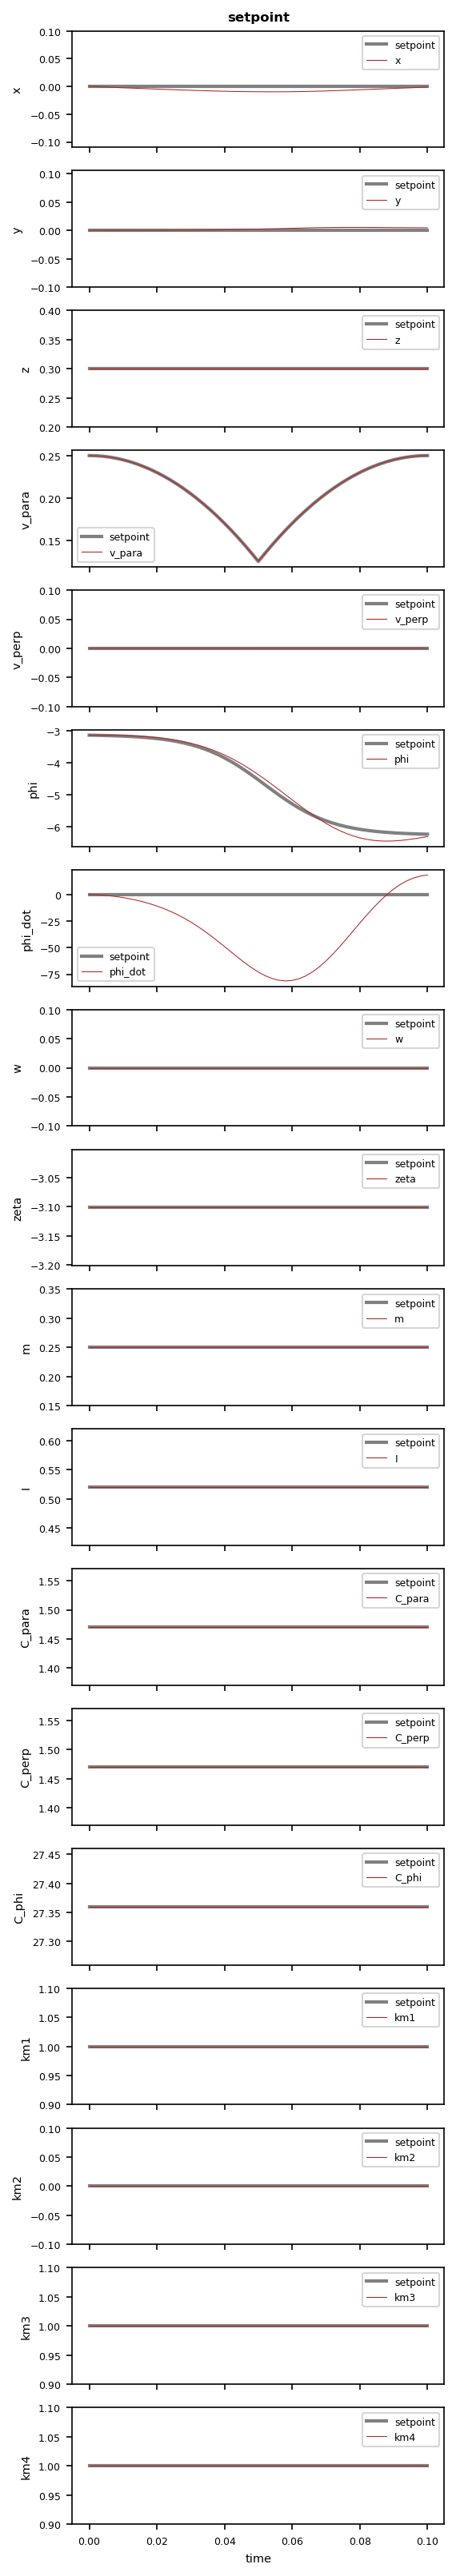

In [61]:
# Plot set-point tracking
# Note that the cost function defined above & the controllability of each state will determine if a set-point is tracked or not
simulator.plot('setpoint')

In [89]:
x_sim['x'] #- simulator.x['x']

array([ 0.        , -0.00049975, -0.0009987 , -0.0014961 , -0.0019911 ,
       -0.00248288, -0.00297065, -0.00345355, -0.00393073, -0.00440127,
       -0.00486418, -0.00531839, -0.00576268, -0.00619569, -0.00661583,
       -0.00702125, -0.00740981, -0.00777901, -0.00812602, -0.00844767,
       -0.00874055, -0.00900112, -0.00922601, -0.00941227, -0.00955771,
       -0.0096618 , -0.00972933, -0.00976005, -0.00974621, -0.00968147,
       -0.00956189, -0.00938622, -0.00915597, -0.00887508, -0.00854943,
       -0.00818603, -0.00779226, -0.00737513, -0.00694079, -0.00649411,
       -0.00603868, -0.00557681, -0.00510976, -0.00463804, -0.00416172,
       -0.00368069, -0.00319492, -0.00270464, -0.00221039, -0.00171306,
       -0.00121384])

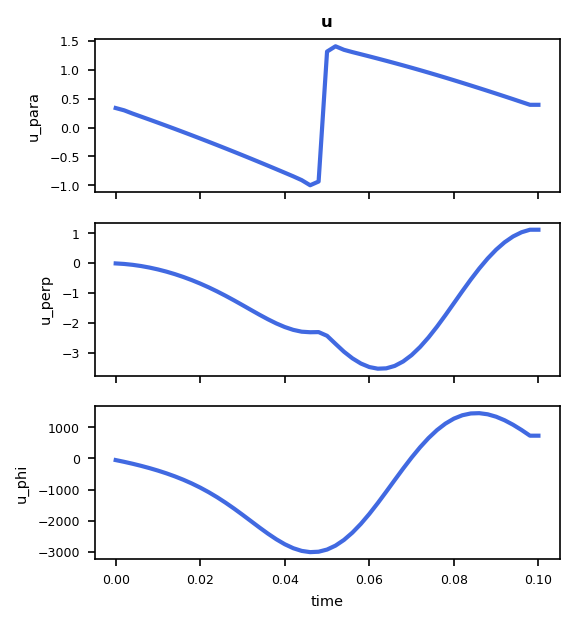

In [62]:
# Plot inputs
simulator.plot('u')

# Re-run simulator with MPC inputs
This step isn't required, but it shows how the closed-loop MOC inputs can be replayed in open-loop to get the same state trajectory

In [63]:
u_sim

{'u_para': array([ 0.33680681,  0.29721399,  0.24111072,  0.18890301,  0.13658464,
         0.08363574,  0.03008332, -0.02406507, -0.07881054, -0.13415487,
        -0.19009961, -0.2466464 , -0.30379624, -0.36154811, -0.41989978,
        -0.47884573, -0.53837617, -0.59847746, -0.65913089, -0.72031247,
        -0.78194675, -0.84394695, -0.90979399, -0.99823259, -0.93377958,
         1.31315672,  1.40444715,  1.34335702,  1.30368102,  1.26690912,
         1.22956175,  1.19163659,  1.15310969,  1.11390361,  1.07395376,
         1.03321374,  0.99165481,  0.94928007,  0.9061162 ,  0.86220763,
         0.81761816,  0.77240059,  0.72661813,  0.68031695,  0.6335306 ,
         0.58627142,  0.53854432,  0.49029783,  0.44124926,  0.39268702,
         0.39268702]),
 'u_perp': array([-0.00606462, -0.02375993, -0.05305334, -0.09368116, -0.1454147 ,
        -0.20806018, -0.28147927, -0.36560106, -0.46041485, -0.56593305,
        -0.68212584, -0.80882118, -0.94557398, -1.09150961, -1.2451527 ,
        

In [70]:
#t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, mpc=False, u=u_sim, return_full_output=True)
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0={'w':0.1,'zeta':np.pi/2}, mpc=False, u=u_sim, return_full_output=True)

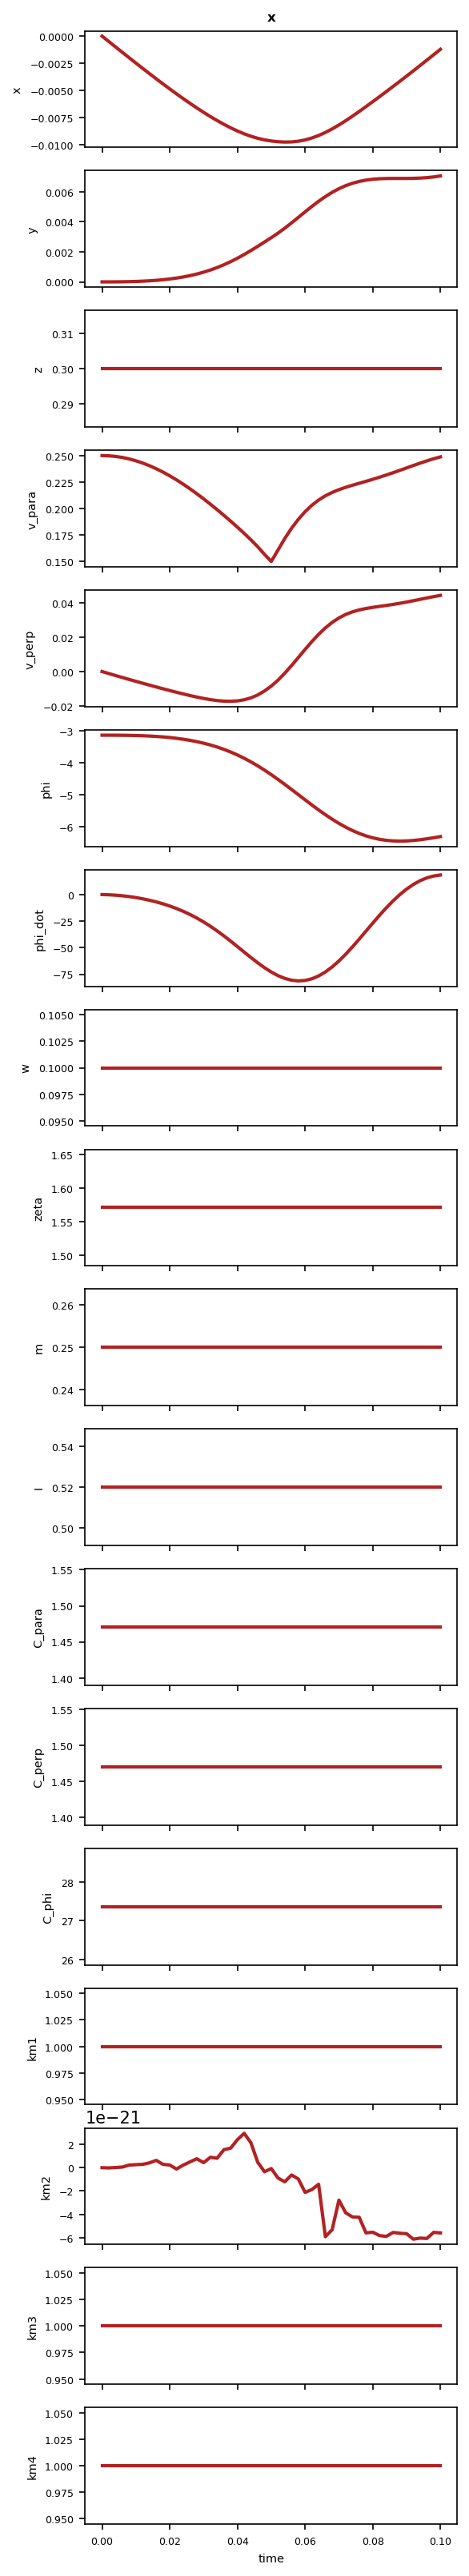

In [71]:
# Plot state
simulator.plot('x')

# Observability

## Construct observability matrix in sliding windows

In [15]:
w = 4  # window size, set to None to use entire time-series as one window

In [16]:
# Construct O in sliding windows
st = time.time()
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)
et = time.time()
print('elapsed time:', et-st)

elapsed time: 2.513667345046997


In [17]:
# Get O's
O_sliding = SEOM.get_observability_matrix()

In [18]:
n_window = len(O_sliding)
print(n_window, 'windows')

37 windows


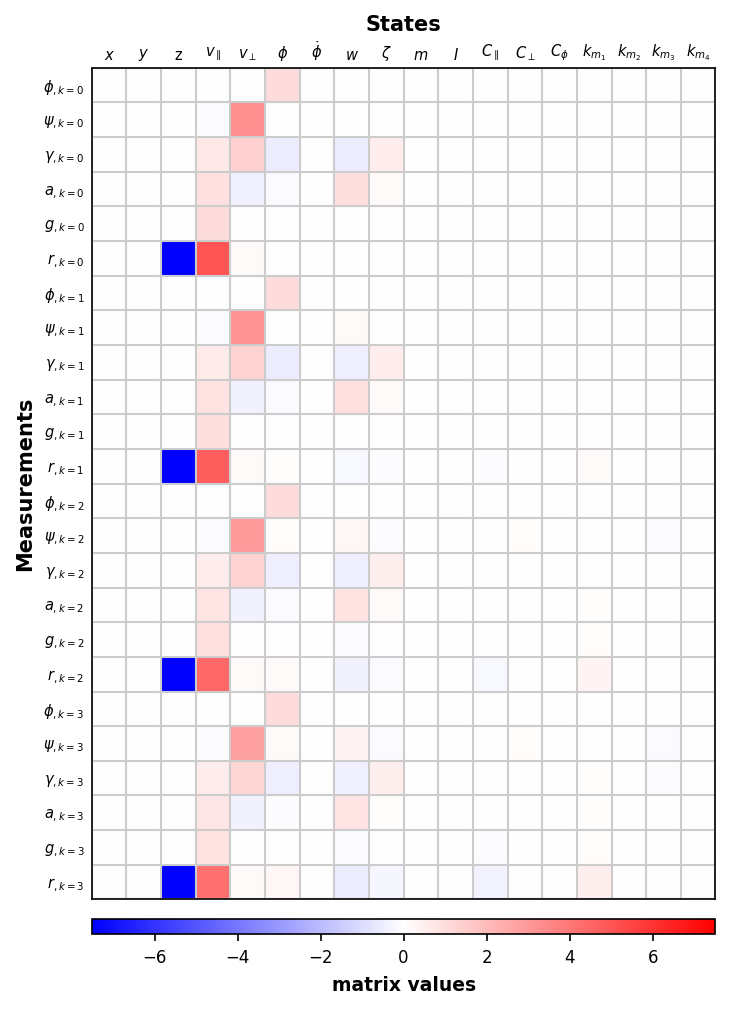

In [19]:
# Visualize first sliding observability matrix, this will throw errors if O is too big
OI = ObservabilityMatrixImage(O_sliding[0], cmap='bwr')
OI.plot(scale=1.0)

## Compute Fisher information matrix & inverse for first window


In [20]:
# Set each sensor noise level
R = {'phi': 0.1, 'psi': 0.1, 'gamma': 0.1, 'a': 0.1, 'g': 0.1, 'r': 0.1}

In [21]:
# Compute the Fisher information & Chernoff inverse
FO = FisherObservability(SEOM.O_df_sliding[0], R=R, lam=1e-6)

# Can also set R directly as matrix or as scalar
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1*np.eye(O_sliding[0].shape[0]), lam=1e-6)
# FO = FisherObservability(SEOM.O_df_sliding[0], R=0.1, lam=1e-6)

In [22]:
SEOM.O_df_sliding[0]

,,x,y,z,v_para,v_perp,phi,phi_dot,w,zeta,m,I,C_para,C_perp,C_phi,km1,km2,km3,km4
sensor,time_step,,,,,,,,,,,,,,,,,,
phi,0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
psi,0,0.000000e+00,0.000000e+00,0.000000,-1.109878e-01,3.329634e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
gamma,0,0.000000e+00,0.000000e+00,0.000000,6.588036e-01,1.407327e+00,-0.584390,0.000000e+00,-5.292859e-01,5.843900e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
a,0,0.000000e+00,0.000000e+00,0.000000,9.056767e-01,-4.239691e-01,-0.136247,0.000000e+00,9.402015e-01,1.362475e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
g,0,0.000000e+00,0.000000e+00,0.000000,9.994449e-01,3.331483e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
r,0,0.000000e+00,0.000000e+00,-7.504167,4.997225e+00,1.665741e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
phi,1,0.000000e+00,0.000000e+00,0.000000,2.777778e-09,-5.689893e-10,1.000000,7.779407e-03,2.714495e-10,-2.697842e-10,-6.661338e-12,-7.451817e-08,-1.121325e-10,1.243450e-10,-2.836620e-10,1.665335e-10,6.923655e-05,-1.804112e-10,4.650169e-08
psi,1,0.000000e+00,0.000000e+00,0.000000,-1.057435e-01,3.138524e+00,0.051974,-7.313819e-03,1.389972e-01,-5.197450e-02,-1.391324e-03,7.138557e-08,2.539498e-03,3.527458e-02,2.737741e-10,-3.743044e-03,-6.642560e-05,-5.151806e-02,-4.461261e-08
gamma,1,0.000000e+00,0.000000e+00,0.000000,6.208697e-01,1.327007e+00,-0.550943,-7.536040e-03,-4.993143e-01,5.509427e-01,-8.019885e-04,7.288087e-08,-1.491058e-02,1.491453e-02,2.783884e-10,2.197717e-02,-6.776683e-05,-2.178247e-02,-4.551443e-08


In [23]:
# Get the Fisher information, inverse, and R matrix
F, F_inv, R_matrix = FO.get_fisher_information()
F_inv

,x,y,z,v_para,v_perp,phi,phi_dot,w,zeta,m,I,C_para,C_perp,C_phi,km1,km2,km3,km4
x,1.000000e+06,-3.606469e-04,-1.103472e-07,-0.000352,-0.000512,-0.000912,0.209032,1.230185e-07,6.179281e-08,-6.840318,0.001541,1.267586,-0.496610,4.518375e-05,0.820845,-4.838439,-0.252826,-0.002038
y,-3.606429e-04,1.000000e+06,-8.667798e-08,-0.000402,-0.000586,-0.001044,0.239251,1.035337e-07,8.630832e-08,-7.823334,0.001763,1.454075,-0.568043,5.169957e-05,0.940978,-5.535319,-0.289273,-0.002331
z,-1.105861e-07,-8.689915e-08,1.153122e-02,0.016632,0.000556,-0.000007,0.000710,-1.136797e-02,-3.040989e-02,-0.009499,-0.000002,0.000934,0.000215,-3.779382e-08,0.000676,0.005359,0.000009,0.000002
v_para,-3.516695e-04,-4.024063e-04,1.663168e-02,0.027136,0.000438,0.000366,-0.021922,-1.710744e-02,-4.548733e-02,-13.131815,0.000334,1.810425,-0.345309,7.542645e-06,1.038738,-0.889697,0.089632,-0.000380
v_perp,-5.124268e-04,-5.863447e-04,5.558432e-04,0.000438,0.006263,-0.000256,0.344984,1.073843e-03,-5.370316e-03,5.805345,0.004336,0.769389,-1.480347,1.382279e-04,0.591651,-14.346452,-0.997460,-0.006036
phi,-9.120199e-04,-1.043891e-03,-7.297960e-06,0.000366,-0.000256,0.067488,-5.119045,8.277808e-06,2.502733e-02,2.885848,-0.007338,1.558201,-2.110367,-1.283172e-04,1.089313,13.505111,-0.998766,0.007321
phi_dot,2.090332e-01,2.392505e-01,7.102369e-04,-0.021922,0.344984,-5.119045,901.897346,-8.114022e-04,-2.644469e-03,-734.445220,13.200954,-374.599813,476.335147,8.771532e-02,-263.933051,-14574.452828,297.932905,-9.260996
w,1.228212e-07,1.041811e-07,-1.136797e-02,-0.017107,0.001074,0.000008,-0.000811,3.615692e-02,4.009973e-02,0.014179,0.000002,-0.017076,-0.022825,-1.380055e-08,0.022278,-0.005816,0.032855,-0.000002
zeta,5.991306e-08,8.861278e-08,-3.040989e-02,-0.045487,-0.005370,0.025027,-0.002644,4.009973e-02,1.903352e-01,0.030146,0.000005,-0.026855,0.021891,-1.460751e-07,0.032416,-0.020785,-0.032659,-0.000009
m,-6.840042e+00,-7.823286e+00,-9.498777e-03,-13.131815,5.805345,2.885848,-734.445220,1.417887e-02,3.014561e-02,395544.453281,-17.324254,62628.532990,10052.318447,-3.279012e-01,47162.835795,18478.175356,-2932.570735,17.940780


## Compute Fisher information matrix & inverse for each sliding window

In [24]:
# Choose sensors to use from O
o_sensors = ['phi', 'psi', 'gamma']

# Chose states to use from O
o_states = ['v_para', 'v_perp', 'phi', 'phi_dot', 'w', 'zeta', 'z', 'm', 'I', 'C_para', 'C_perp', 'C_phi']

# Choose time-steps to use from O
window_size = 4
o_time_steps = np.arange(0, window_size, step=1)

In [25]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-6, R=R,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

In [26]:
# Pull out minimum error variance, 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
EV_aligned = SFO.get_minimum_error_variance()

In [27]:
EV_aligned

,time,time_initial,v_para,v_perp,phi,phi_dot,w,zeta,z,m,I,C_para,C_perp,C_phi
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02,0.00,226328.031260,251.555252,0.078679,691.277080,130026.072356,685804.536115,1000000.0,873715.384432,999999.942861,476221.398715,468768.765182,999999.999931
3,0.03,0.01,222914.830377,252.797080,0.078740,692.075219,128665.262020,675456.192464,1000000.0,942820.935632,999999.979657,477118.987290,468916.630449,999999.999927
4,0.04,0.02,227785.373655,262.855333,0.078529,689.356179,129898.820976,689502.823816,1000000.0,998531.241803,999999.914339,477657.873743,469059.735478,999999.999958
5,0.05,0.03,227744.840775,267.807716,0.078530,689.356946,129816.912700,689768.741147,1000000.0,998536.605547,999999.885659,477651.932605,469053.220486,999999.999989
6,0.06,0.04,227672.793396,272.766633,0.078531,689.364515,129725.437000,689941.942109,1000000.0,998535.706533,999999.898166,477646.482263,469046.724662,999999.999999
7,0.07,0.05,227607.305974,277.773645,0.078531,689.369345,129636.191382,690134.141719,1000000.0,998534.975130,999999.930149,477640.794071,469040.414598,999999.999990
8,0.08,0.06,227538.438441,282.817026,0.078519,689.223286,129545.839518,690315.421817,1000000.0,998534.314256,999999.962581,477635.144004,469034.075393,999999.999971
9,0.09,0.07,227457.480759,287.884904,0.078518,689.207678,129451.611252,690459.726532,1000000.0,998532.949516,999999.985795,477630.401938,469027.039443,999999.999952


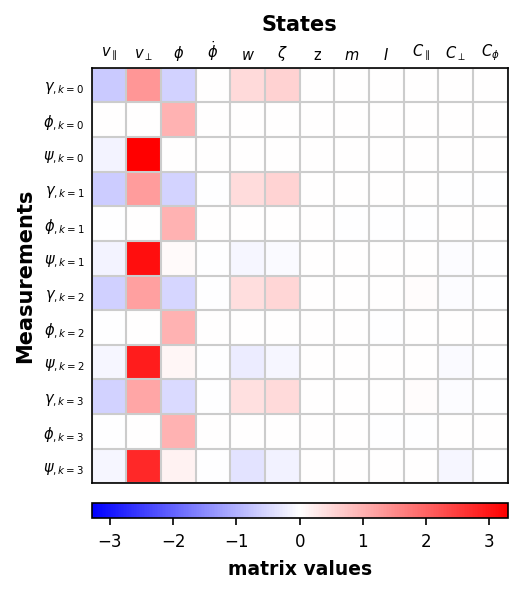

In [28]:
# Visualize observability matrix subset
OI = ObservabilityMatrixImage(SFO.FO[-1].O)
OI.plot()

# Plot error variance as color on state time-series

In [29]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

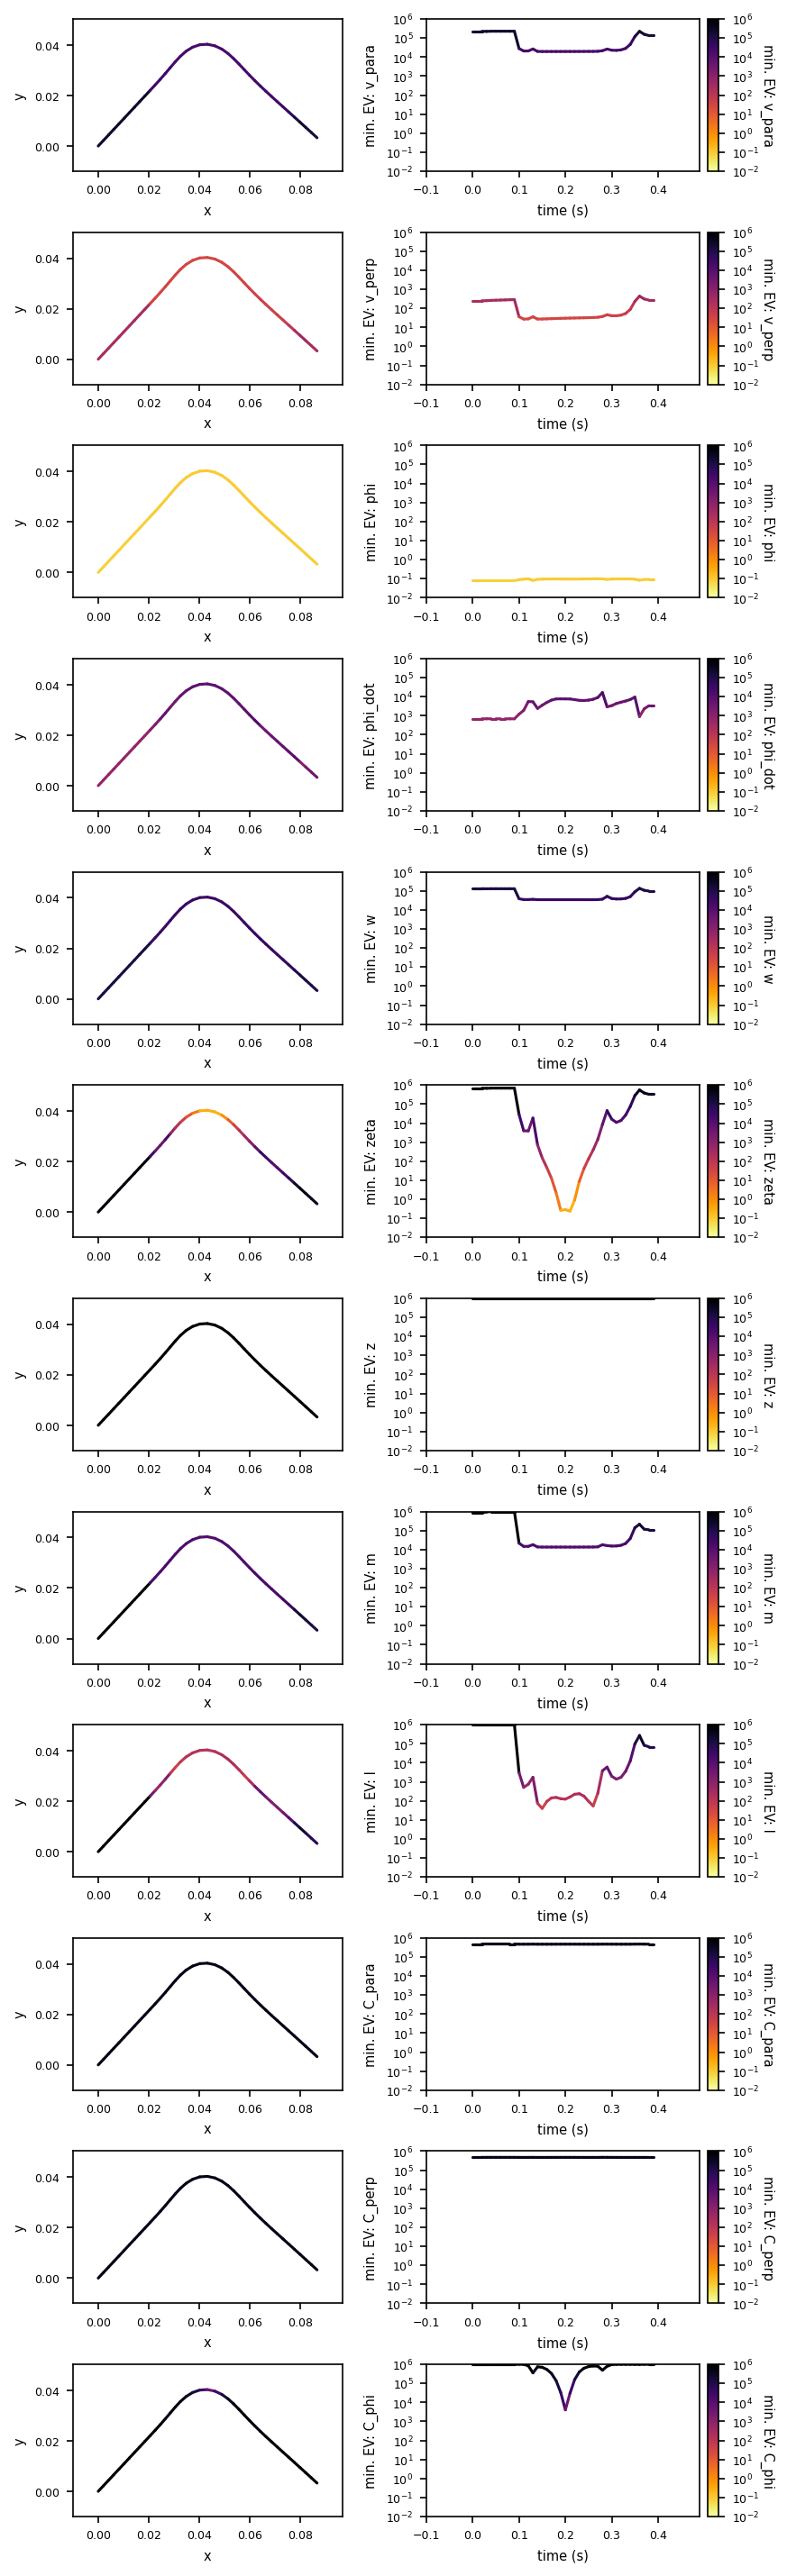

In [30]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(x_sim['x'], x_sim['y'], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(np.min(x_sim['y']) - 0.01, np.max(x_sim['y']) + 0.01)
    ax[n, 0].set_xlim(np.min(x_sim['x']) - 0.01, np.max(x_sim['x']) + 0.01)
    ax[n, 0].set_ylabel('y', fontsize=7)
    ax[n, 0].set_xlabel('x', fontsize=7)
    ax[n, 0].set_aspect(1.0)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)

for a in ax[:, 1]:
    a.set_xlabel('time (s)', fontsize=7)
    a.set_xlim(-0.1, t_sim[-1] + 0.1)

# for a in ax[:, 1]:
#     a.set_xlim(-0.1, t_sim[-1] + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()